In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
final_dataset_featured=pd.read_csv('final_train.csv')

In [64]:
final_dataset_featured.shape

(5281, 311)

Final touch to model

We will first need to drop the provider column and then make the training data. Also, we need to scale the dataset

In [3]:
Training_Label=final_dataset_featured['Provider']
Training_Final=final_dataset_featured.drop(columns='Provider',axis=1)

In [4]:
Training_Final.shape

(5281, 310)

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
Training_Final.isnull().sum()

PotentialFraud                                            0
InscClaimAmtReimbursed                                    0
DeductibleAmtPaid                                         0
Hospitalization_Duration                                  0
Claim_Period                                              0
ExtraClaimDays                                            0
is_admitted                                               0
RenalDiseaseIndicator                                     0
NoOfMonths_PartACov                                       0
NoOfMonths_PartBCov                                       0
ChronicCond_Alzheimer                                     0
ChronicCond_Heartfailure                                  0
ChronicCond_KidneyDisease                                 0
ChronicCond_Cancer                                        0
ChronicCond_ObstrPulmonary                                0
ChronicCond_Depression                                    0
ChronicCond_Diabetes                    

In [6]:
y = Training_Final['PotentialFraud']
X = Training_Final.drop('PotentialFraud', axis=1)

In [7]:
##Split the trainng and testing dataset
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=42)

StandardScaler

In [8]:
from sklearn.preprocessing import StandardScaler

def apply_standard_scaler(X_train, X_test=None):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    if X_test is not None:
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    return X_train_scaled


In [9]:
X_train_scaled, X_test_scaled = apply_standard_scaler(X_train, X_test)


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

def get_threshold_fpr_tpr(y, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
    return fpr, tpr, thresholds

def draw_ROC_AUC_plot(train_fpr, train_tpr, test_fpr, test_tpr):
    plt.plot(train_fpr, train_tpr, label="Train AUC = " + str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="Test AUC = " + str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid()
    plt.show()

def find_best_threshold(thresholds, fpr, tpr):
    t = thresholds[np.argmax(tpr * (1 - fpr))]
    print("The maximum value of tpr*(1-fpr)", max(tpr * (1 - fpr)), "for threshold", np.round(t, 3))
    return t

def predict_with_best_threshold(proba, threshold):
    predictions = []
    for i in proba:
        if i >= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def get_confusion_matrix(y, y_pred,axis, best_t):
    cm = pd.DataFrame(confusion_matrix(y, predict_with_best_threshold(y_pred, best_t)))
    sns.heatmap(cm, annot = True, fmt= 'd',annot_kws={"size": 15}, xticklabels= ['Predicted No', 'Predicted Yes'], yticklabels= ['Actaual No','Actual Yes'],ax=axis)



In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

In [12]:
###UTILITY FUNCTIONS
def model_performance_check(model,X_train,X_test,y_train,y_test):

    y_train_pred = model.predict_proba(X_train)[:,1]
    y_test_pred = model.predict_proba(X_test)[:,1]

    train_fpr, train_tpr, tr_thresholds = get_threshold_fpr_tpr(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = get_threshold_fpr_tpr(y_test, y_test_pred)

    #plot Roc_AUC_curve
    draw_ROC_AUC_plot(train_fpr, train_tpr,test_fpr, test_tpr)

    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

    #draw confusion matrix
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

    #training confusion matrix heatmap
    get_confusion_matrix(y_train, y_train_pred,ax[0], best_t)
    ax[0].set_title("confusion matrix for traning data")

    #test confusion matrix heatmap
    get_confusion_matrix(y_test, y_test_pred,ax[1], best_t)
    ax[1].set_title("confusion matrix for test data")

    actual_output = y_test
    pred_output = predict_with_best_threshold(y_test_pred, best_t)

    model_f1_score = metrics.f1_score(actual_output,pred_output)
    print("Model test F1 score is : ",model_f1_score)

    model_AUC_score = metrics.auc(test_fpr, test_tpr)
    print("Model test AUC score is : ",model_AUC_score)

    return (model_f1_score, model_AUC_score)

RANDOM FOREST CLASSIFIER

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

RF = RandomForestClassifier(class_weight = 'balanced', random_state=42)

param_grid = {
    'n_estimators': [500, 800],
    'max_features': ['auto', 'sqrt', '0.2','log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' : ['gini', 'entropy','log_loss']
}
    

RF_CV = GridSearchCV(
    estimator=RF, 
    param_grid=param_grid, 
    cv= 10, 
    scoring='roc_auc', 
    n_jobs=-1, 
    return_train_score=True, 
    verbose=10
    )
RF_CV.fit(X_train_scaled, y_train)

print("tuned hpyerparameters :(best parameters) ",RF_CV.best_params_)
print("roc_auc :",RF_CV.best_score_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


c:\Users\jhauj\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
600 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jhauj\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jhauj\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\Users\jhauj\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\jhauj\anaconda3\lib\site-package

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 800}
roc_auc : 0.9363211189394327


In [14]:
RF2 = RandomForestClassifier(n_estimators = 800,max_features='auto',max_depth=4,criterion='entropy',
                             class_weight = 'balanced',n_jobs=-1,verbose=10, random_state=42)

RF2=RF2.fit(X_train_scaled,y_train)
print("score",RF2.score(X_test_scaled,y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    0.1s


building tree 1 of 800
building tree 2 of 800
building tree 3 of 800
building tree 4 of 800
building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800
building tree 9 of 800
building tree 10 of 800
building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800
building tree 18 of 800
building tree 19 of 800
building tree 20 of 800
building tree 21 of 800
building tree 22 of 800
building tree 23 of 800
building tree 24 of 800
building tree 25 of 800
building tree 26 of 800
building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800
building tree 32 of 800
building tree 33 of 800
building tree 34 of 800
building tree 35 of 800
building tree 36 of 800
building tree 37 of 800
building tree 38 of 800
building tree 39 of 800
building tree 40 of 800
building tree 41 of 800
building tree 42 of 800
b

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.3s


building tree 154 of 800building tree 155 of 800

building tree 156 of 800
building tree 157 of 800
building tree 158 of 800
building tree 159 of 800
building tree 160 of 800
building tree 161 of 800
building tree 162 of 800
building tree 163 of 800
building tree 164 of 800
building tree 165 of 800
building tree 166 of 800
building tree 167 of 800
building tree 168 of 800
building tree 169 of 800
building tree 170 of 800
building tree 171 of 800
building tree 172 of 800
building tree 173 of 800
building tree 174 of 800
building tree 175 of 800
building tree 176 of 800
building tree 177 of 800
building tree 178 of 800
building tree 179 of 800
building tree 180 of 800
building tree 181 of 800
building tree 182 of 800
building tree 183 of 800
building tree 184 of 800
building tree 185 of 800
building tree 186 of 800
building tree 187 of 800
building tree 188 of 800
building tree 189 of 800
building tree 190 of 800
building tree 191 of 800
building tree 192 of 800
building tree 193 of 800


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    0.6s


building tree 228 of 800
building tree 229 of 800
building tree 230 of 800
building tree 231 of 800
building tree 232 of 800
building tree 233 of 800
building tree 234 of 800
building tree 235 of 800
building tree 236 of 800
building tree 237 of 800
building tree 238 of 800
building tree 239 of 800
building tree 240 of 800
building tree 241 of 800
building tree 242 of 800
building tree 243 of 800
building tree 244 of 800
building tree 245 of 800
building tree 246 of 800
building tree 247 of 800
building tree 248 of 800
building tree 249 of 800
building tree 250 of 800
building tree 251 of 800
building tree 252 of 800
building tree 253 of 800
building tree 254 of 800
building tree 255 of 800
building tree 256 of 800
building tree 257 of 800
building tree 258 of 800
building tree 259 of 800
building tree 260 of 800
building tree 261 of 800
building tree 262 of 800
building tree 263 of 800
building tree 264 of 800
building tree 265 of 800
building tree 266 of 800
building tree 267 of 800


[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    0.8s


building tree 301 of 800building tree 302 of 800
building tree 303 of 800

building tree 304 of 800
building tree 305 of 800
building tree 306 of 800
building tree 307 of 800
building tree 308 of 800
building tree 309 of 800
building tree 310 of 800
building tree 311 of 800
building tree 312 of 800
building tree 313 of 800
building tree 314 of 800
building tree 315 of 800
building tree 316 of 800
building tree 317 of 800
building tree 318 of 800
building tree 319 of 800
building tree 320 of 800
building tree 321 of 800
building tree 322 of 800
building tree 323 of 800
building tree 324 of 800
building tree 325 of 800
building tree 326 of 800
building tree 327 of 800
building tree 328 of 800
building tree 329 of 800
building tree 330 of 800
building tree 331 of 800
building tree 332 of 800
building tree 333 of 800
building tree 334 of 800
building tree 335 of 800
building tree 336 of 800
building tree 337 of 800
building tree 338 of 800
building tree 339 of 800
building tree 340 of 800


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:    1.1s


building tree 371 of 800
building tree 372 of 800
building tree 373 of 800
building tree 374 of 800
building tree 375 of 800
building tree 376 of 800
building tree 377 of 800
building tree 378 of 800
building tree 379 of 800
building tree 380 of 800
building tree 381 of 800
building tree 382 of 800
building tree 383 of 800
building tree 384 of 800
building tree 385 of 800
building tree 386 of 800
building tree 387 of 800
building tree 388 of 800
building tree 389 of 800
building tree 390 of 800
building tree 391 of 800
building tree 392 of 800
building tree 393 of 800
building tree 394 of 800
building tree 395 of 800
building tree 396 of 800
building tree 397 of 800
building tree 398 of 800
building tree 399 of 800
building tree 400 of 800
building tree 401 of 800
building tree 402 of 800
building tree 403 of 800
building tree 404 of 800
building tree 405 of 800
building tree 406 of 800
building tree 407 of 800
building tree 408 of 800
building tree 409 of 800
building tree 410 of 800


[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:    1.3s


building tree 495 of 800
building tree 496 of 800
building tree 497 of 800
building tree 498 of 800
building tree 499 of 800
building tree 500 of 800
building tree 501 of 800
building tree 502 of 800
building tree 503 of 800
building tree 504 of 800
building tree 505 of 800
building tree 506 of 800
building tree 507 of 800
building tree 508 of 800
building tree 509 of 800
building tree 510 of 800
building tree 511 of 800
building tree 512 of 800
building tree 513 of 800
building tree 514 of 800
building tree 515 of 800
building tree 516 of 800
building tree 517 of 800
building tree 518 of 800
building tree 519 of 800
building tree 520 of 800
building tree 521 of 800
building tree 522 of 800
building tree 523 of 800
building tree 524 of 800
building tree 525 of 800
building tree 526 of 800
building tree 527 of 800
building tree 528 of 800
building tree 529 of 800
building tree 530 of 800
building tree 531 of 800
building tree 532 of 800
building tree 533 of 800
building tree 534 of 800


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed:    1.5s


building tree 548 of 800
building tree 549 of 800
building tree 550 of 800
building tree 551 of 800
building tree 552 of 800
building tree 553 of 800
building tree 554 of 800
building tree 555 of 800
building tree 556 of 800
building tree 557 of 800
building tree 558 of 800
building tree 559 of 800
building tree 560 of 800
building tree 561 of 800
building tree 562 of 800
building tree 563 of 800
building tree 564 of 800
building tree 565 of 800
building tree 566 of 800
building tree 567 of 800
building tree 568 of 800
building tree 569 of 800
building tree 570 of 800
building tree 571 of 800
building tree 572 of 800
building tree 573 of 800
building tree 574 of 800
building tree 575 of 800
building tree 576 of 800
building tree 577 of 800
building tree 578 of 800
building tree 579 of 800
building tree 580 of 800
building tree 581 of 800
building tree 582 of 800
building tree 583 of 800
building tree 584 of 800
building tree 585 of 800
building tree 586 of 800
building tree 587 of 800


[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:    1.7s


building tree 611 of 800
building tree 612 of 800
building tree 613 of 800
building tree 614 of 800
building tree 615 of 800
building tree 616 of 800
building tree 617 of 800
building tree 618 of 800
building tree 619 of 800
building tree 620 of 800
building tree 621 of 800
building tree 622 of 800
building tree 623 of 800
building tree 624 of 800
building tree 625 of 800
building tree 626 of 800
building tree 627 of 800
building tree 628 of 800
building tree 629 of 800
building tree 630 of 800
building tree 631 of 800
building tree 632 of 800
building tree 633 of 800
building tree 634 of 800
building tree 635 of 800
building tree 636 of 800
building tree 637 of 800
building tree 638 of 800
building tree 639 of 800
building tree 640 of 800
building tree 641 of 800
building tree 642 of 800
building tree 643 of 800
building tree 644 of 800
building tree 645 of 800
building tree 646 of 800
building tree 647 of 800
building tree 648 of 800
building tree 649 of 800
building tree 650 of 800


[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:    2.0s


building tree 672 of 800
building tree 673 of 800
building tree 674 of 800
building tree 675 of 800
building tree 676 of 800
building tree 677 of 800
building tree 678 of 800
building tree 679 of 800
building tree 680 of 800
building tree 681 of 800
building tree 682 of 800
building tree 683 of 800
building tree 684 of 800
building tree 685 of 800
building tree 686 of 800
building tree 687 of 800
building tree 688 of 800
building tree 689 of 800
building tree 690 of 800
building tree 691 of 800
building tree 692 of 800
building tree 693 of 800
building tree 694 of 800
building tree 695 of 800
building tree 696 of 800
building tree 697 of 800
building tree 698 of 800
building tree 699 of 800
building tree 700 of 800
building tree 701 of 800
building tree 702 of 800
building tree 703 of 800
building tree 704 of 800
building tree 705 of 800
building tree 706 of 800
building tree 707 of 800
building tree 708 of 800
building tree 709 of 800
building tree 710 of 800
building tree 711 of 800


[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:    2.2s


building tree 741 of 800
building tree 742 of 800
building tree 743 of 800
building tree 744 of 800
building tree 745 of 800
building tree 746 of 800
building tree 747 of 800
building tree 748 of 800
building tree 749 of 800
building tree 750 of 800
building tree 751 of 800
building tree 752 of 800
building tree 753 of 800
building tree 754 of 800
building tree 755 of 800
building tree 756 of 800
building tree 757 of 800
building tree 758 of 800
building tree 759 of 800
building tree 760 of 800
building tree 761 of 800
building tree 762 of 800
building tree 763 of 800
building tree 764 of 800
building tree 765 of 800
building tree 766 of 800
building tree 767 of 800
building tree 768 of 800
building tree 769 of 800
building tree 770 of 800
building tree 771 of 800
building tree 772 of 800
building tree 773 of 800
building tree 774 of 800
building tree 775 of 800
building tree 776 of 800
building tree 777 of 800
building tree 778 of 800
building tree 779 of 800
building tree 780 of 800


[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Para

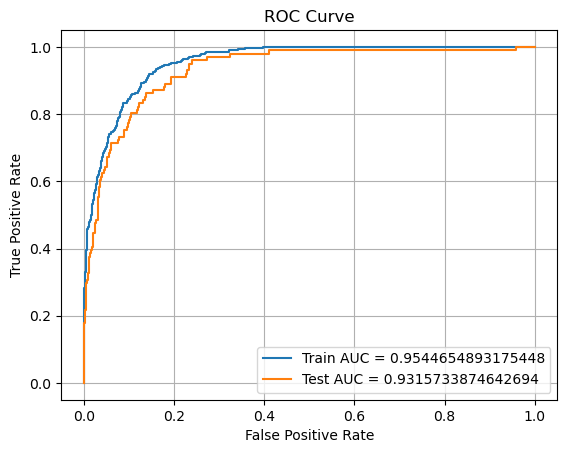

The maximum value of tpr*(1-fpr) 0.7852744076886522 for threshold 0.448
Model test F1 score is :  0.5240963855421686
Model test AUC score is :  0.9315733874642694


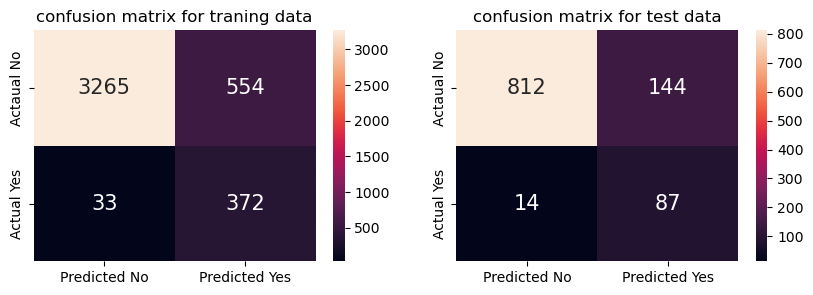

In [15]:
model_f1_score, model_AUC_score = model_performance_check(RF2,X_train_scaled,X_test_scaled,y_train,y_test)

LOGISTIC REGRESSION

In [22]:
grid={"C":np.logspace(-4,4,50), "penalty":['l2','none']}

logreg=LogisticRegression(max_iter=990)
logreg_cv=GridSearchCV(
    logreg,
    grid,
    cv=5, 
    n_jobs=-1, 
    return_train_score=True)
logreg_cv.fit(X_train_scaled,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)


tuned hpyerparameters :(best parameters)  {'C': 2.559547922699533, 'penalty': 'l2'}
accuracy : 0.9367918337586584


In [23]:
logreg2=LogisticRegression(C=2.559547922699533,penalty="l2")
logreg2.fit(X_train_scaled,y_train)
print("score",logreg2.score(X_test_scaled,y_test))

score 0.9290444654683065


c:\Users\jhauj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


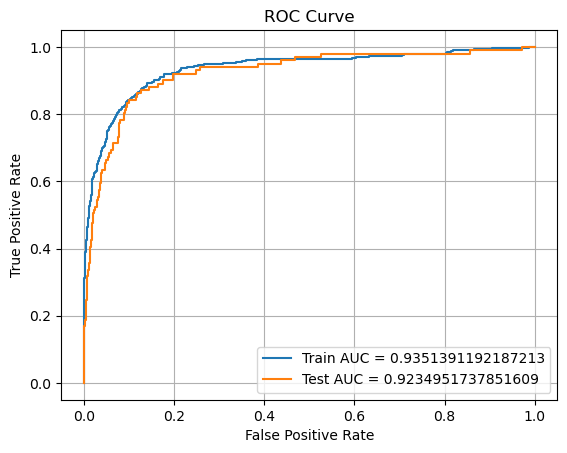

The maximum value of tpr*(1-fpr) 0.766021743136171 for threshold 0.055
Model test F1 score is :  0.5250737463126844
Model test AUC score is :  0.9234951737851609


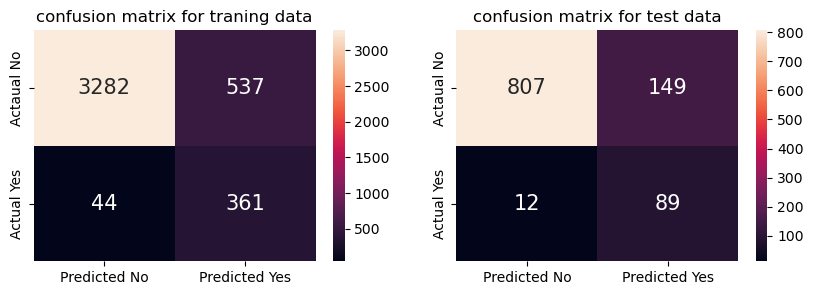

In [24]:
model_f1_score, model_AUC_score = model_performance_check(logreg2,X_train_scaled,X_test_scaled,y_train,y_test)

In [59]:
def model_comp(label=[],metric1=[],metric2=[],set_ylabel='',set_title='',metric1_label='',metric2_label=''):

    x = np.arange(len(model))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12,5))
    rects1 = ax.bar(x - width/2, metric1, width, label=metric1_label,color = 'teal')
    rects2 = ax.bar(x + width/2, metric2, width, label=metric2_label)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(set_ylabel)
    ax.set_title(set_title)
    ax.set_xticks(x)
    ax.set_xticklabels(model)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

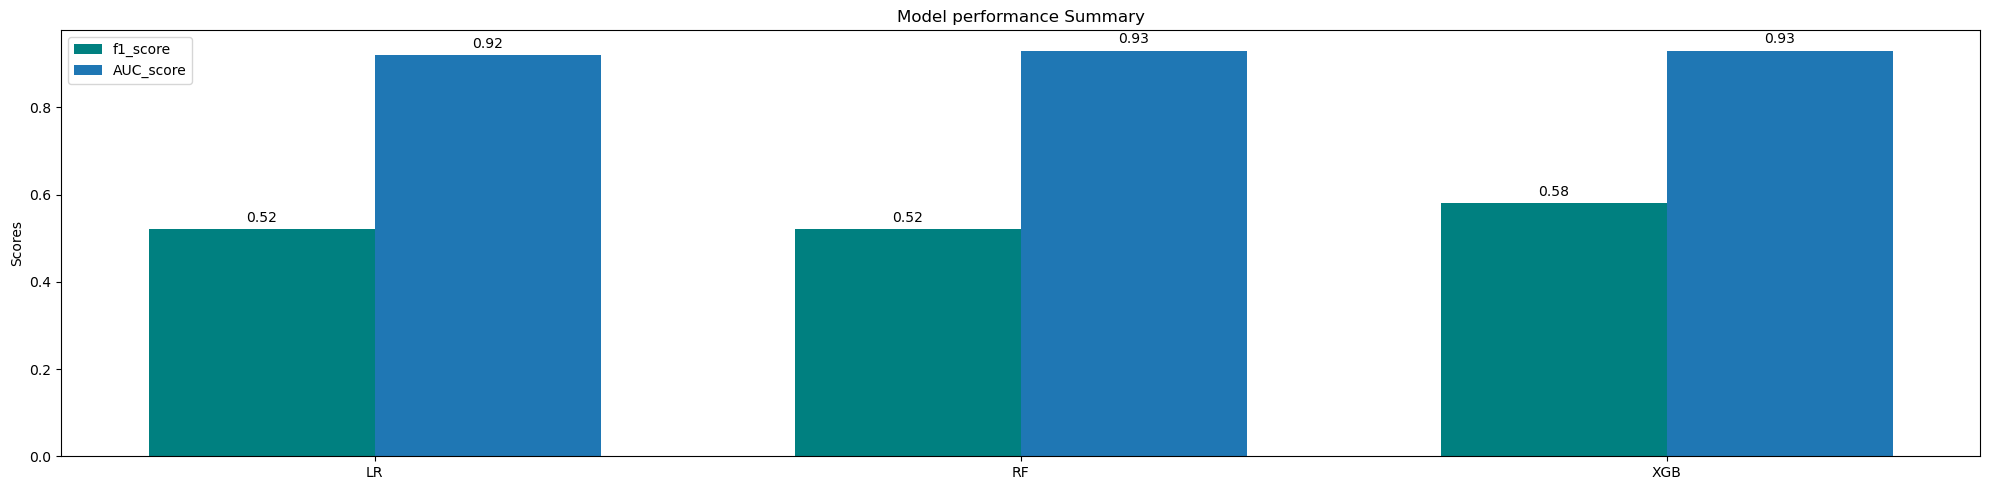

In [56]:
model = ['LR','RF', 'XGB']
f1_score = [0.52,0.52,0.58]
AUC_score = [0.92,0.93, 0.93]

model_comp(model,f1_score,AUC_score,'Scores','Model performance Summary','f1_score','AUC_score')

FEATURE SELECTION USING FEATURE IMPORTANCE


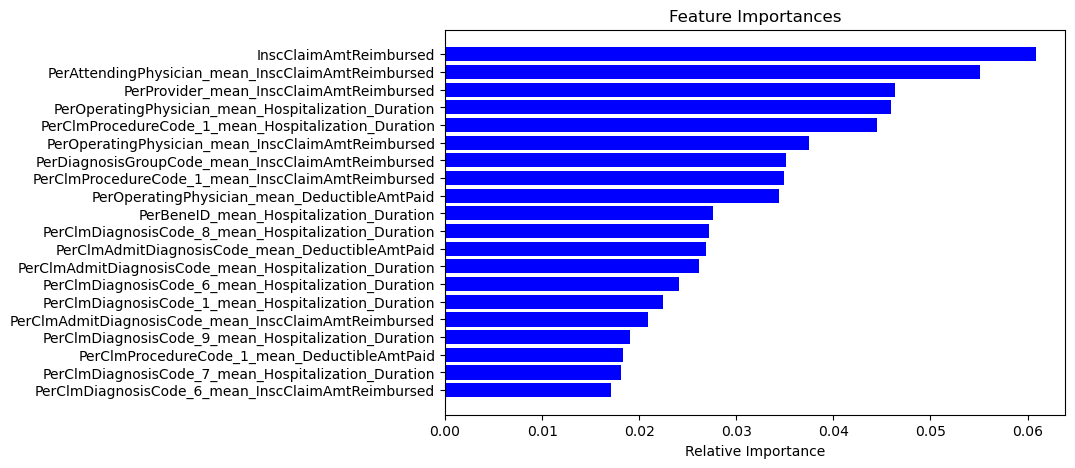

In [57]:
#for random  forest classifier

features =X.columns
importances = RF2.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(8,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig('feature.png')
plt.show()


In [65]:
column_names = ['PerClmDiagnosisCode_6_mean_InscClaimAmtReimbursed',
'PerClmDiagnosisCode_7_mean_Hospitalization_Duration',
'PerClmProcedureCode_1_mean_DeductibleAmtPaid',
'PerClmDiagnosisCode_9_mean_Hospitalization_Duration',
'PerClmAdmitDiagnosisCode_mean_InscClaimAmtReimbursed',
'PerClmDiagnosisCode_1_mean_Hospitalization_Duration',
'PerClmDiagnosisCode_6_mean_Hospitalization_Duration',
'PerClmAdmitDiagnosisCode_mean_Hospitalization_Duration',
'PerClmAdmitDiagnosisCode_mean_DeductibleAmtPaid',
'PerClmDiagnosisCode_8_mean_Hospitalization_Duration',
'PerBeneID_mean_Hospitalization_Duration',
'PerOperatingPhysician_mean_DeductibleAmtPaid',
'PerClmProcedureCode_1_mean_InscClaimAmtReimbursed',
'PerDiagnosisGroupCode_mean_InscClaimAmtReimbursed',
'PerOperatingPhysician_mean_InscClaimAmtReimbursed',
'PerClmProcedureCode_1_mean_Hospitalization_Duration',
'PerOperatingPhysician_mean_Hospitalization_Duration',
'PerProvider_mean_InscClaimAmtReimbursed',
'PerAttendingPhysician_mean_InscClaimAmtReimbursed',
'InscClaimAmtReimbursed']

In [66]:
column_indices = [X_train.columns.get_loc(name) for name in column_names]

In [67]:
X_train1 = X_train_scaled[:, column_indices]
X_test1 = X_test_scaled[:, column_indices]

In [68]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(class_weight = 'balanced', random_state=42)

param_grid = {
    'n_estimators': [300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}


RF_CV = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5,scoring='roc_auc', n_jobs=-1, return_train_score=True, verbose=10)
RF_CV.fit(X_train1, y_train)

print("tuned hpyerparameters :(best parameters) ",RF_CV.best_params_)
print("roc_auc :",RF_CV.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}
roc_auc : 0.9387042581592432


In [69]:
RF2 = RandomForestClassifier(n_estimators = 500,max_features='auto',max_depth=5,criterion='entropy',
                             class_weight = 'balanced',n_jobs=-1,verbose=1, random_state=42)

RF2=RF2.fit(X_train1,y_train)

print("score",RF2.score(X_test1,y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


score 0.8741721854304636


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


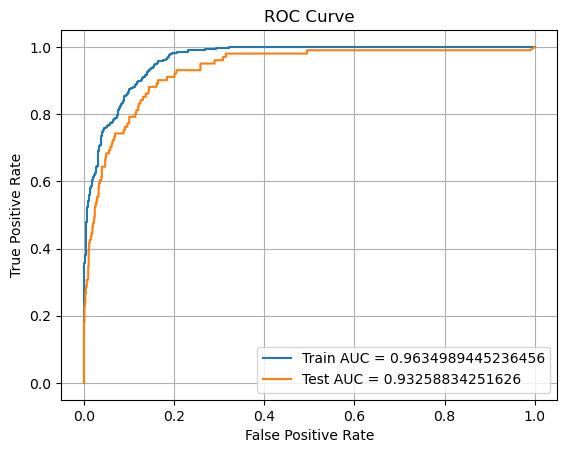

The maximum value of tpr*(1-fpr) 0.8014896278839719 for threshold 0.35
Model test F1 score is :  0.4906666666666667
Model test AUC score is :  0.93258834251626


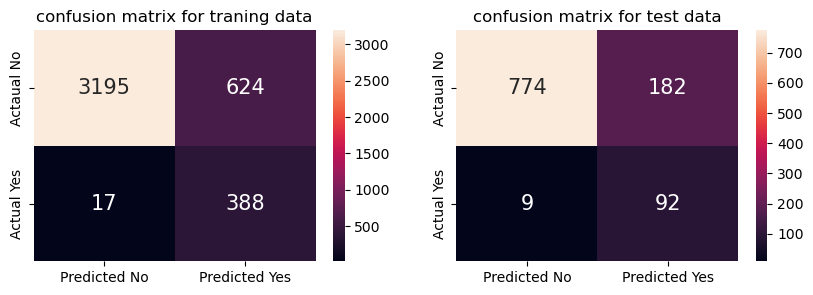

In [70]:
model_f1_score, model_AUC_score = model_performance_check(RF2,X_train1,X_test1,y_train,y_test)

LOGISTIC REGRESSION

In [72]:
grid={"C":np.logspace(-3,3,7), "penalty":['l2','none']}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10,  n_jobs=-1, return_train_score=True)
logreg_cv.fit(X_train1,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)


tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2'}
accuracy : 0.9341848453273279


In [73]:
logreg2=LogisticRegression(C=0.01,penalty='l2')
logreg2.fit(X_train1,y_train)
print("score",logreg2.score(X_test1,y_test))

score 0.9280983916745507


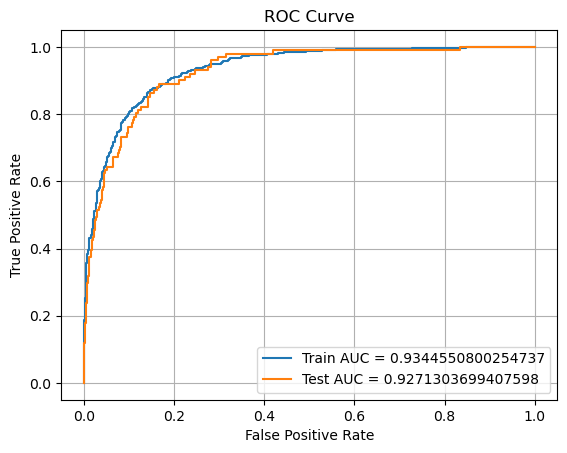

The maximum value of tpr*(1-fpr) 0.7431122490213002 for threshold 0.062
Model test F1 score is :  0.5176470588235295
Model test AUC score is :  0.9271303699407598


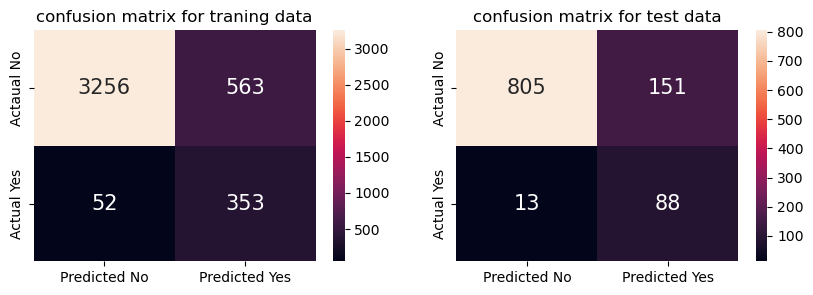

In [74]:
model_f1_score, model_AUC_score = model_performance_check(logreg2,X_train1,X_test1,y_train,y_test)

USING ANOTHER ALGORITHM-XGBOOST ALGORITHM

In [25]:
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

XGB = xgb.XGBClassifier()

parameters = {"eta" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] , "n_estimators" : [5,10,50, 75, 100]}

XGB_CV = RandomizedSearchCV(XGB, parameters , cv=5, scoring='roc_auc', n_jobs=-1,return_train_score=True, verbose=10)
XGB_CV.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",XGB_CV.best_params_)
print("roc_auc :",XGB_CV.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
tuned hpyerparameters :(best parameters)  {'n_estimators': 50, 'eta': 0.2}
roc_auc : 0.932111783912623


In [26]:
XGB2 = xgb.XGBClassifier(eta=0.2,n_estimators=50,n_jobs=-1)

XGB2=XGB2.fit(X_train,y_train)

print("score",XGB2.score(X_test,y_test))

score 0.9214758751182592


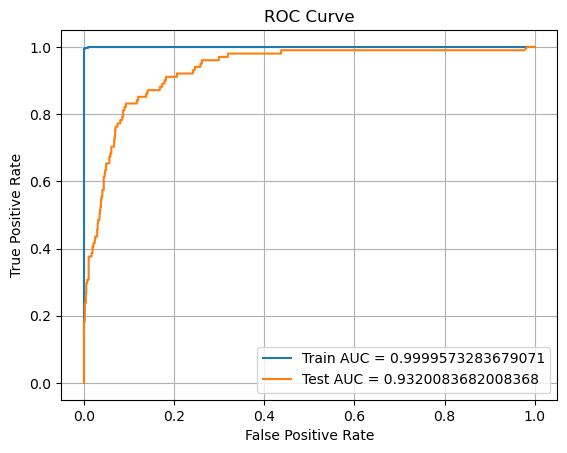

The maximum value of tpr*(1-fpr) 0.99439643885834 for threshold 0.312
Model test F1 score is :  0.5800000000000001
Model test AUC score is :  0.9320083682008368


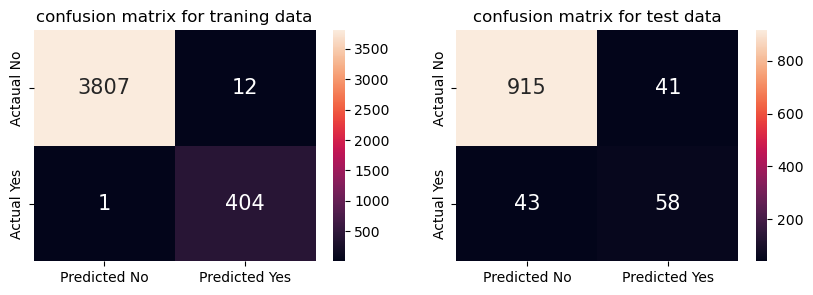

In [27]:
model_f1_score, model_AUC_score = model_performance_check(XGB2,X_train,X_test,y_train,y_test)

In [82]:
x = np.array(list(map(int, np.linspace(1, 31, 31))))
x

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [83]:
np.repeat(x, len(x))

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,
        8,  8,  8,  8,  8

In [84]:
np.tile(x, len(x))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
       30, 31,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3,  4,
        5,  6,  7,  8,  9

In [88]:
parameters = { 
        'hidden_layer_sizes' : list(zip(np.tile(x, len(x)), np.repeat(x, len(x))))
}
parameters

{'hidden_layer_sizes': [(1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (1, 2),
  (2, 2),
  (3, 2),
  (4, 2),
  (5, 2),
  (6, 2),
  (7, 2),
  (8, 2),
  (9, 2),
  (10, 2),
  (11, 2),
  (12, 2),
  (13, 2),
  (14, 2),
  (15, 2),
  (16, 2),
  (17, 2),
  (18, 2),
  (19, 2),
  (20, 2),
  (21, 2),
  (22, 2),
  (23, 2),
  (24, 2),
  (25, 2),
  (26, 2),
  (27, 2),
  (28, 2),
  (29, 2),
  (30, 2),
  (31, 2),
  (1, 3),
  (2, 3),
  (3, 3),
  (4, 3),
  (5, 3),
  (6, 3),
  (7, 3),
  (8, 3),
  (9, 3),
  (10, 3),
  (11, 3),
  (12, 3),
  (13, 3),
  (14, 3),
  (15, 3),
  (16, 3),
  (17, 3),
  (18, 3),
  (19, 3),
  (20, 3),
  (21, 3),
  (22, 3),
  (23, 3),
  (24, 3),
  (25, 3),
  (26, 3),
  (27, 3),
  (28, 3),
  (29, 3),
  (3

In [31]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': XGB2.feature_importances_})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()

,Features,Importance_Model_1
0,InscClaimAmtReimbursed,0.074031
1,DeductibleAmtPaid,0.005966
2,Hospitalization_Duration,0.004045
3,Claim_Period,0.002256
4,ExtraClaimDays,0.005999


In [36]:
top_10_pos_feats = feats_imps.sort_values(
    by='Importance_Model_1',
    axis=0,
    ascending=False
    )['Features'].iloc[0:10]
top_10_pos_feats_scores = feats_imps.sort_values(
    by='Importance_Model_1',
    axis=0,
    ascending=False
    )['Importance_Model_1'].iloc[0:10]

In [37]:
label_font_dict = {'family':'sans-serif','size':13.5,'color':'brown','style':'italic'}
title_font_dict = {'family':'sans-serif','size':16.5,'color':'Blue','style':'italic'}

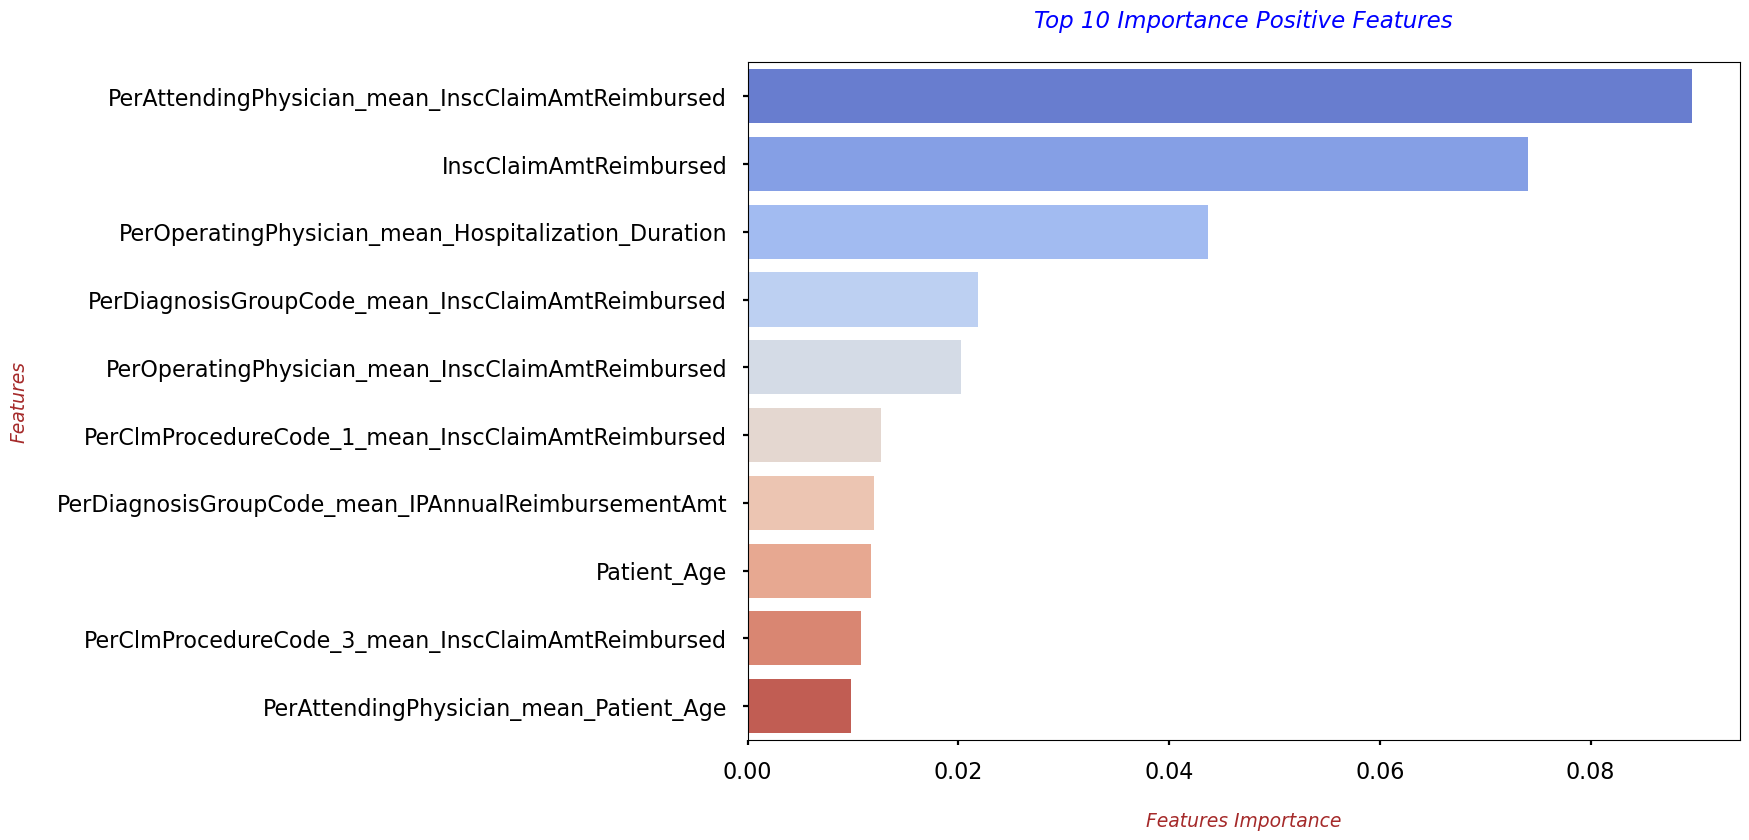

In [39]:
with plt.style.context('seaborn-poster'):
    sns.barplot(
        y=top_10_pos_feats, 
        x=top_10_pos_feats_scores, 
        orient='h', 
        palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 10 Importance Positive Features\n", fontdict=title_font_dict)

In [41]:
rfc_6 = RandomForestClassifier(n_estimators=30,criterion='gini',
                                   max_depth= 4,
                                   max_features='auto',
                                   min_samples_leaf=100,
                                   min_samples_split=50,
                                   random_state=49,
                                   min_weight_fraction_leaf=0.0,
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   ccp_alpha=0.0,)

rfc_6.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=4, min_samples_leaf=100, min_samples_split=50,
                       n_estimators=30, random_state=49)

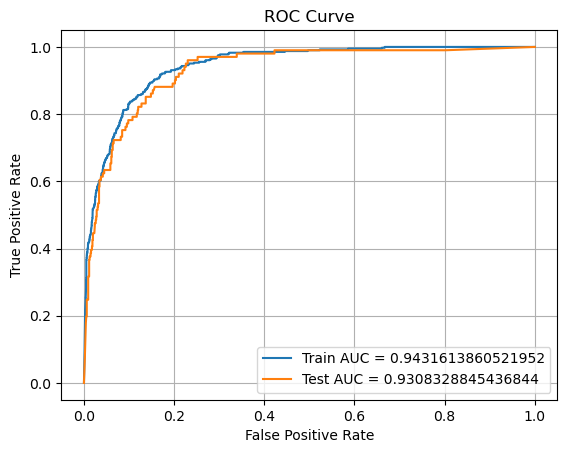

The maximum value of tpr*(1-fpr) 0.7629067139933858 for threshold 0.089
Model test F1 score is :  0.4863387978142076
Model test AUC score is :  0.9308328845436844


### Model AUC is : 0.9308
### Model Train F1 Score is : 0.4863


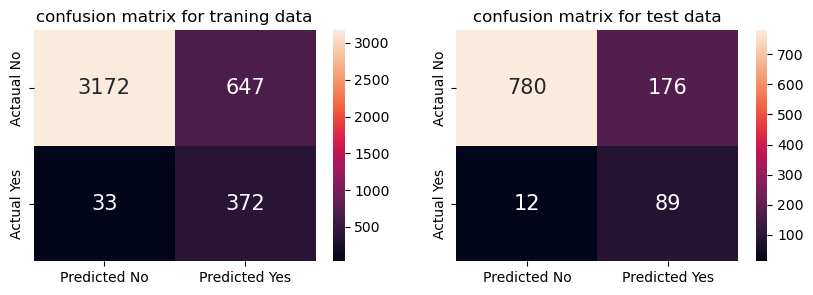

In [46]:
# Validate model
model_f1_score, model_AUC_score = model_performance_check(rfc_6,X_train_scaled, X_test_scaled, y_train, y_test)

print("\n")
print("### Model AUC is : {:.4f}".format(model_AUC_score))
print("### Model Train F1 Score is : {:.4f}".format(model_f1_score))

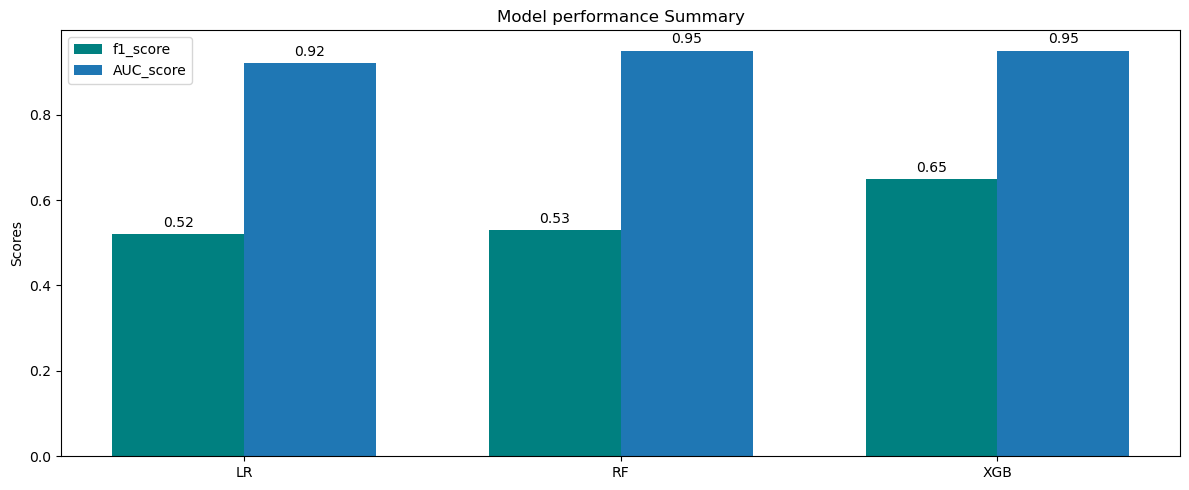

In [66]:
model_last = [
    'LR', 
    'RF',
    'XGB']
f1_score_last = [
    0.52,
    0.53,
    0.65]
AUC_score_last = [
    0.92,
    0.95,
    0.95]

model_comp(model_last,f1_score_last,AUC_score_last,'Scores','Model performance Summary','f1_score','AUC_score')